In [2]:
import pandas as pd
import os
import torch
import torch.nn as nn
import copy
from datetime import datetime
import numpy as np
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

now = datetime.now()
print('data preprocess start : {}'.format(now.strftime("%H:%M:%S")))

# 讀取sensor data，path設定為不同data的位置
path_normal = './data/normal'
path_public = './data/public'
path_private = './data/private'

# 處理normal data，集合成normal_pdList(list of Dataframe), [0:4]->[A,B,C,D,E]
normal_pdList = []
for filename in os.listdir(path_normal):
    subPath = path_normal + '/' + filename
    sensorType = filename[7]
    tmp = pd.read_csv(subPath, skiprows=1, names=[sensorType])
    normal_pdList.append(tmp)

# 處理public data，集合成public_pdList(list of Dataframe), [0:4]->[A,B,C,D,E]
public_pdList = []
# 處理public data label，集合成publicLabel_pdList(list of Dataframe), [0:4]->[A,B,C,D,E]
publicLabel_pdList = []
publicValid_pdList = []
for filename in os.listdir(path_public):
    subPath = path_public + '/' + filename
    sensorType = filename[7]
    tmp = pd.read_csv(subPath, skiprows=1, names=[sensorType, sensorType + '_label'])
    tmp_valid = tmp.loc[tmp[sensorType + '_label']==0][sensorType]
    public_pdList.append(pd.DataFrame(tmp, columns=[sensorType]))
    publicLabel_pdList.append(pd.DataFrame(tmp, columns=[sensorType+ '_label']))
    publicValid_pdList.append(pd.DataFrame((tmp_valid)))

# 處理private data，集合成private_pdList(list of Dataframe), [0:4]->[A,B,C,D,E]
private_pdList = []
for filename in os.listdir(path_private):
    subPath = path_private + '/' + filename
    sensorType = filename[7]
    tmp = pd.read_csv(subPath, skiprows=1, names=[sensorType])
    private_pdList.append(tmp)

del subPath, tmp, now, path_normal, path_private, path_public, filename, sensorType, tmp_valid



randomSeed = 23
# 設定各sensor training data的sequence length
TIME_STEPS = [350, 350, 500, 350, 350]

# Generated training sequences
def create_sequences(df, time_steps=1):
    df_mean = df.mean()
    df_std = df.std()
    df = (df - df_mean) / df_std
    #  df.plot.line()
    values = df.values
    output = []
    for i in range(len(values) - time_steps + 1):
        output.append(values[i: (i + time_steps)])
    return np.stack(output)

# df to tensor
def to_tensor(df):
    sequence = df.astype(np.float32)
    dataset = torch.stack([torch.tensor(s) for s in sequence])
    _, seq_len, n_features = dataset.shape
    return (dataset, seq_len, n_features)


def to_tensor_label(df):
    sequence = df.astype(np.float32).to_numpy()
    dataset = torch.stack([torch.tensor(s) for s in sequence])
    seq_len, n_features = dataset.shape
    return (dataset, seq_len, n_features)


# 處理normal data的轉換，Input:sensorID(A~E對應0~4)，Output:train, valid, test(tensor), n_feature
def trans_normal(sensorID):
    train = normal_pdList[sensorID]
    original_train = create_sequences(train, time_steps=1)
    train = create_sequences(train, time_steps=TIME_STEPS[sensorID])
    original_train, _, _ = to_tensor(original_train)
    train, _, n_feature = to_tensor(train)
    return train, n_feature, original_train


# 處理public data的轉換，Input:sensorID(A~E對應0~4)，Output:public, publicLabel
def trans_public(sensorID):
    public = public_pdList[sensorID]
    public.plot.line()
    public = create_sequences(public, time_steps=1)
    public, _, _ = to_tensor(public)
    publicLabel = publicLabel_pdList[sensorID]
    publicLabel, _, _ = to_tensor_label(publicLabel)
    publicValid = publicValid_pdList[sensorID]
    publicValid = create_sequences(publicValid, time_steps=1)
    publicValid, _, _ = to_tensor(publicValid)
    return public, publicLabel, publicValid


# 處理private data的轉換，Input:sensorID(A~E對應0~4)，Output:private
def trans_private(sensorID):
    private = private_pdList[sensorID]
    #  private.plot.line()
    private = create_sequences(private, time_steps=1)
    private, _, _ = to_tensor(private)
    return private


sensorDict = {"A": 0, "B": 1, "C": 2, "D": 3, "E": 4}

# 將sensor的normal data轉為tensor
normalA_train, A_n_feature, originalA_train = trans_normal(sensorDict["A"])
normalB_train, B_n_feature, originalB_train = trans_normal(sensorDict["B"])
normalC_train, C_n_feature, originalC_train = trans_normal(sensorDict["C"])
normalD_train, D_n_feature, originalD_train = trans_normal(sensorDict["D"])
normalE_train, E_n_feature, originalE_train = trans_normal(sensorDict["E"])
# 將sensor的public data轉為tensor
publicA, publicA_label, publicA_valid = trans_public(sensorDict["A"])
publicB, publicB_label, publicB_valid = trans_public(sensorDict["B"])
publicC, publicC_label, publicC_valid = trans_public(sensorDict["C"])
publicD, publicD_label, publicD_valid = trans_public(sensorDict["D"])
publicE, publicE_label, publicE_valid = trans_public(sensorDict["E"])
# publicA_valid = publicA[:1500]
# 將sensor的private data轉為tensor
privateA = trans_private(sensorDict["A"])
privateB = trans_private(sensorDict["B"])
privateC = trans_private(sensorDict["C"])
privateD = trans_private(sensorDict["D"])
privateE = trans_private(sensorDict["E"])

now = datetime.now()
print('data preprocess done : {}'.format(now.strftime("%H:%M:%S")))

data preprocess start : 18:36:31
data preprocess done : 18:36:32


In [3]:
# input (n_feature=1) -> hidden (2*embed_dim) -> output (embed_dim)
class encoder(nn.Module):
    def __init__(self, embed_dim, n_feature=1):
        super(encoder, self).__init__()
        
        self.n_feature = n_feature
        self.hidden_dim = 2 * embed_dim
        self.embed_dim = embed_dim

        # (n_feature -> hidden_dim)
        self.lstm1 = nn.LSTM(
            input_size = self.n_feature,
            hidden_size = self.hidden_dim,
            num_layers = 1,
            batch_first = True,
        )
        
        # lstm weight initialization    
        for name, param in self.lstm1.named_parameters():
            nn.init.uniform_(param, -0.1, 0.1)

        # fully-connected layer         
        self.encoder_fc = nn.Linear(self.hidden_dim, self.embed_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)
        self.dropout2 = nn.Dropout(0.2)
        
    def forward(self, x):
        seq_len = x.shape[1]
        batchSize = x.shape[0]
        x = x.reshape((batchSize, seq_len, self.n_feature))
        out, (_, _) = self.lstm1(x)
        out = self.dropout1(out)
        out = self.encoder_fc(out)
        out = self.dropout2(out)
        out = self.relu1(out)
        return out

    
# input (embed_dim) -> hidden (2*embed_dim) -> output (n_feature=1)
class decoder(nn.Module):
    def __init__(self, embed_dim, n_feature=1):
        super(decoder, self).__init__()

        self.embed_dim = embed_dim
        self.hidden_dim = 2 * embed_dim
        self.n_feature = n_feature
        
        # hidden_dim -> n_feature      
        self.lstm1 = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.n_feature,
            num_layers=1,
            batch_first=True
        )
        
        # lstm weight initialization
        for name, param in self.lstm1.named_parameters():
            nn.init.uniform_(param, -0.1, 0.1)
        
        # fully-connected layer  
        self.decoder_fc = nn.Linear(self.embed_dim, self.hidden_dim)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(0.2)

    def forward(self, x):
        out = self.decoder_fc(x)
        out = self.dropout1(out)
        out = self.relu1(out)
        out, (_, _) = self.lstm1(out)
        return out


class autoencoder(nn.Module):
    def __init__(self, embed_dim=64, n_feature=1):
        super(autoencoder, self).__init__()
        self.encoder = encoder(embed_dim=embed_dim, n_feature=n_feature)
        self.decoder = decoder(embed_dim=embed_dim, n_feature=n_feature)

    def initialize_weights(self):
        for m in self.encoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()
        for m in self.decoder.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()

    def forward(self, x):
        out = self.encoder(x)
        out = self.decoder(out)
        out = out.squeeze(0)
        return out


def train_model(model, train_dataset, valid_dataset, public_dataset, public_label, private_dataset, epoch_num, lr=0.0001, batchSize=64):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.L1Loss(reduction='sum')
    history = dict(train=[], roc=[], valid=[])
    best_model = model.state_dict()
    best_roc, best_loss, roc = 0, 1000, 0
    es_stop, patient=0, 10

    train_dataset = DataLoader(train_dataset, batch_size=batchSize)
    valid_dataset = DataLoader(valid_dataset, batch_size=batchSize)

    model = model.eval()
    with torch.no_grad():      
        pred_public_loss = predict(model, public_dataset)
        roc = roc_auc_score(public_label, pred_public_loss)
    print(roc)
    
    for epoch in range(1, epoch_num + 1):
        model = model.train()
        train_loss = []
        valid_loss = []
        
        # batch training         
        for _, seq_true in enumerate(train_dataset):
            seq_pred = model(seq_true)
            optimizer.zero_grad()
            loss = criterion(seq_pred, seq_true)
            train_loss.append(loss.item()/batchSize)
            loss.backward()
            optimizer.step()
        
        # valid evaluation         
        model = model.eval()
        with torch.no_grad():
            for _,seq_true in enumerate(valid_dataset):
                seq_pred = model(seq_true)
                loss = criterion(seq_pred, seq_true)
                valid_loss.append(loss.item()/batchSize)
  
            pred_public_loss = predict(model, public_dataset)
            roc = roc_auc_score(public_label, pred_public_loss)
            pred_private_loss = predict(model, private_dataset)


        train_loss = np.mean(train_loss)
        valid_loss = np.mean(valid_loss)

        history['train'].append(train_loss)
        history['valid'].append(valid_loss)
        history['roc'].append(roc)


        if roc > best_roc or (valid_loss<best_loss and roc>=best_roc):
            es_stop = 0 
            best_loss = valid_loss
            best_roc = roc
            best_predPublicLoss = pred_public_loss
            best_predPrivateLoss = pred_private_loss
            best_model = model.state_dict()
            print('save here')
        else:
            es_stop += 1
            if es_stop > patient:
                print("Early stopping with best_roc: ", best_roc)
                break
                
        print(f'Epoch {epoch}: train loss {train_loss}  valid loss {valid_loss} best loss {best_loss} roc {roc}')
        now = datetime.now()
        print('epoch done : {}'.format(now.strftime("%H:%M:%S")))
        
    model.load_state_dict(best_model)
    return model.eval(), history, best_roc, best_loss, best_predPublicLoss, best_predPrivateLoss



def evaluate(model, dataset, label):
    losses = predict(model, dataset)
    sns.displot(losses, kde=True)
    plt.show()
    roc_score = roc_auc_score(label, losses)
    return roc_score


def predict(model, dataset):
    losses = []
    criterion = nn.L1Loss(reduction='sum')
    with torch.no_grad():
        model = model.eval()
        for seq_true in dataset:
            seq_pred = model(seq_true)
            losses.append(criterion(seq_pred, seq_true).item())
    return losses


EPOCH_NUM = 450
batchSize = 64
model_A = autoencoder(embed_dim=64, n_feature=A_n_feature)
model_A.initialize_weights()
model_B = autoencoder(embed_dim=256, n_feature=B_n_feature)
model_B.initialize_weights()
model_C = autoencoder(embed_dim=128, n_feature=C_n_feature)
model_C.initialize_weights()
model_D = autoencoder(embed_dim=128, n_feature=D_n_feature)
model_D.initialize_weights()
model_E = autoencoder(embed_dim=128, n_feature=E_n_feature)
model_E.initialize_weights()

# DIFFERENT SENSOR
modelList = [model_A ,model_B, model_C, model_D, model_E]
normal_trainList = [normalA_train, normalB_train, normalC_train, normalD_train, normalE_train]
original_trainList = [originalA_train, originalB_train, originalC_train, originalD_train, originalE_train]
publicList = [publicA, publicB, publicC, publicD, publicE]
publicvalidList = [publicA_valid, publicB_valid, publicC_valid, publicD_valid, publicE_valid]
public_labelList = [publicA_label, publicB_label, publicC_label, publicD_label, publicE_label]
privateList = [privateA, privateB, privateC, privateD, privateE]

In [5]:
# 訓練哪個sensor model (0~4)
SENSOR =  2
i = SENSOR
print('-------------------------------------------------------------------------------------------------')
print('model ' + str(i) + ' training')
model, history, best_roc, best_loss, best_predPublicLoss, best_predPrivateLoss = train_model(modelList[i], normal_trainList[i], publicvalidList[i], 
                                                                       publicList[i], public_labelList[i], privateList[i], 
                                                                       epoch_num=EPOCH_NUM, lr=1e-3, batchSize=batchSize)
MODEL_PATH = './model/model_' + str(i) + '.pth'
torch.save(model, MODEL_PATH)

pred_normalTrain_loss = predict(model, original_trainList[i])
threshold = np.percentile(pred_normalTrain_loss, 80)


# 用NORMAL 'Train' DATA丟入MODEL，檢測出的正常預測(應該原本seq len一樣，沒有任何異常seq)
correct = sum(k <= threshold for k in pred_normalTrain_loss)
print(f'Correct normal prediction (train) : {correct}/{len(original_trainList[i])}')

# predict public data score
pred_public_loss = predict(model, publicList[i])
abnomaly = sum(k > threshold for k in pred_public_loss)
print(f'abnomaly prediction (public): {abnomaly}/{len(publicList[i])}')
abnomaly_ans = sum(k == 1 for k in public_labelList[i])
print(f'abnomaly prediction ans (public label): {abnomaly_ans}/{len(public_labelList[i])}')
roc_score = roc_auc_score(public_labelList[i], pred_public_loss)
print(f'roc score: {roc_score}')
best_roc_score = roc_auc_score(public_labelList[i], best_predPublicLoss)
print(f'roc score: {best_roc_score}')


# predict private data score
pred_private_loss = predict(model, privateList[i])
abnomaly = sum(k > threshold for k in pred_private_loss)
print(f'abnomaly prediction (private): {abnomaly}/{len(privateList[i])}')

-------------------------------------------------------------------------------------------------
model 2 training
0.9002344057133861
save here
Epoch 1: train loss 195.6187128769724  valid loss 0.5335436160194462 best loss 0.5335436160194462 roc 0.9002344057133861
epoch done : 18:38:54
save here
Epoch 2: train loss 113.96323510220176  valid loss 0.4570209550960311 best loss 0.4570209550960311 roc 0.9002344057133861
epoch done : 18:40:33
save here
Epoch 3: train loss 108.6727620676944  valid loss 0.4099827526972212 best loss 0.4099827526972212 roc 0.9002344057133861
epoch done : 18:42:08
save here
Epoch 4: train loss 105.83190727233887  valid loss 0.38331506838058604 best loss 0.38331506838058604 roc 0.9002344057133861
epoch done : 18:43:57
save here
Epoch 5: train loss 104.27107037995991  valid loss 0.36830594801697236 best loss 0.36830594801697236 roc 0.9002344057133861
epoch done : 18:45:50
save here
Epoch 6: train loss 103.32163278680099  valid loss 0.3526986213079814 best loss 0.35

C:\Users\Jolian\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


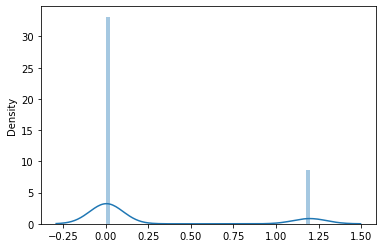

In [6]:
sns.distplot(pred_normalTrain_loss, bins=50, kde=True)

C:\Users\Jolian\Anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


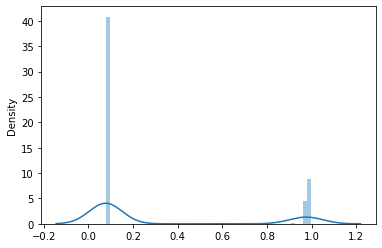

In [7]:
sns.distplot(best_predPublicLoss, bins=50, kde=True)

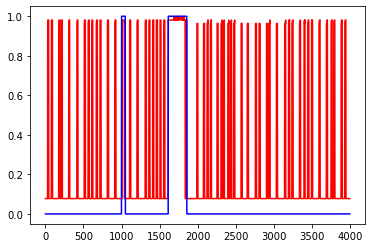

In [8]:
x_ax = torch.arange(0,len(pred_public_loss))
y_ax = best_predPublicLoss
plt.plot(x_ax,y_ax,color = 'r', label=SENSOR)
plt.plot(x_ax,public_labelList[SENSOR], color='b')

In [7]:
# write file (specific the file name)
pd.DataFrame(best_predPublicLoss).to_csv('./result1/C_public.csv')
pd.DataFrame(best_predPrivateLoss).to_csv('./result1/C_private.csv')

In [12]:
# CONCAT RESULT
path_result = './result'

result_pdList = []
for filename in os.listdir(path_result):
    subPath = path_result + '/' + filename
    filename = filename[:-4]
    tmp = pd.read_csv(subPath,skiprows=1, names=['pred'])
    result_pdList.append(tmp)
A_1_private = result_pdList[0]
A_1_public = result_pdList[1]
A_private = result_pdList[2]
A_public = result_pdList[3]
B_private = result_pdList[4]
B_public = result_pdList[5]
C_private = result_pdList[6]
C_public = result_pdList[7]
D_private = result_pdList[8]
D_public = result_pdList[9]
E_private = result_pdList[10]
E_public = result_pdList[11]
# ansnow = pd.concat([A_public,A_private,B_public,B_private,C_public,C_private,D_public,D_private,E_public,E_private],axis=0).reset_index(drop=True)
ansnow = pd.concat([A_1_public,A_1_private,B_public,B_private,C_public,C_private,D_public,D_private,E_public,E_private],axis=0).reset_index(drop=True)
ansnow.index = ansnow.index.set_names(['id'])
ansnow.to_csv('./result/final.csv')

In [13]:
ansnow

,pred
id,
0,0.003687
1,0.003687
2,0.011717
3,0.009216
4,0.007000
...,...
39995,0.058215
39996,0.058215
39997,0.058215
